# Separating Mitochondria Membranes

### importing libraries

In [8]:
import pandas as pd 
import numpy as np
from random import randint
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

## The Gaussian function<br>
$$
f(x) = Ae^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$
<br>
Where: <br>
 - $A$ is height of the curve's peak <br>
 - $\mu$ is the position of the center of the peak (mean) <br>
 - $\sigma$ is the standard deviation <br>

In [2]:
def gaussian(x, p):
    A, mu, sigma = p
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

### The parameters

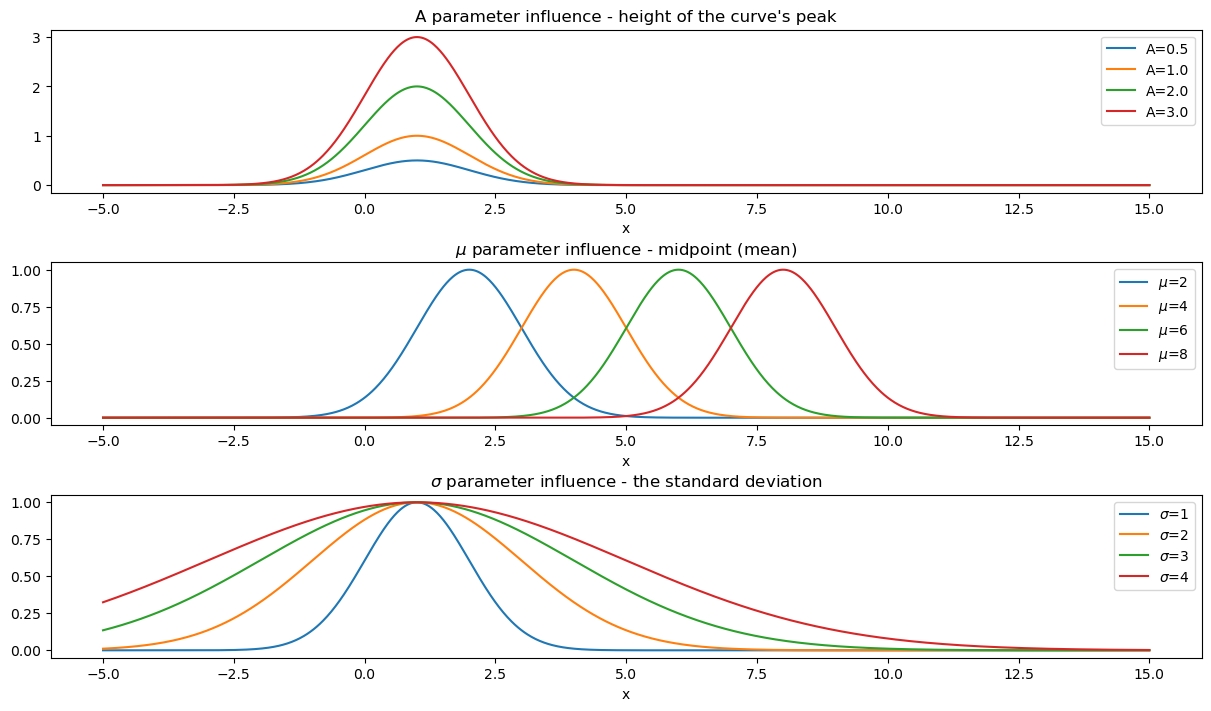

In [3]:
x = np.linspace(-5, 15, 1000)

fig = plt.figure(figsize=(12, 7))

# vary A
ax = fig.add_subplot(3, 1, 1)
for A in [0.5, 1., 2., 3.]:
    f = gaussian(x=x, p=[A, 1, 1])
    _ = plt.plot(x, f, label=f'A={A}')
_ = ax.legend()
_ = ax.set_xlabel('x')
_ = plt.title("A parameter influence - height of the curve's peak")

# vary mu 
ax = fig.add_subplot(3, 1, 2)
for u in [2, 4, 6, 8]:
    f = gaussian(x=x, p=[1, u, 1])
    _ = plt.plot(x, f, label=f'$\mu$={u}')
_ = ax.legend()
_ = ax.set_xlabel('x')
_ = plt.title("$\mu$ parameter influence - midpoint (mean)")

# vary sigma
ax = fig.add_subplot(3, 1, 3)
for s in [1, 2, 3, 4]:
    f = gaussian(x=x, p=[1, 1, s])
    _ = plt.plot(x, f, label=f'$\sigma$={s}')
_ = ax.legend()
_ = ax.set_xlabel('x')
_ = plt.title("$\sigma$ parameter influence - the standard deviation")

fig.tight_layout(pad=0.3)
plt.show();

### import raw data

In [9]:
data_folder = '.\data'
files = os.listdir(data_folder)
# choose file from files
file_name = files[randint(0, len(files)-1)]
print(file_name)

A14.xlsx


In [10]:
raw_data = pd.read_excel(os.path.join(data_folder, file_name))
raw_data.rename({raw_data.columns[0]: 'X', raw_data.columns[1]: 'GFP',raw_data.columns[2]: 'mCherry'}, axis=1, inplace=True)
raw_data.head()

,X,GFP,mCherry
0,0.000000,116.250,119.000
1,0.033854,133.562,137.615
2,0.067708,136.500,158.350
3,0.101562,130.959,163.863
4,0.135417,156.620,193.900


## Helper function
This function plot two serieses, that share the x-axis, but have different y-axis.
* Red is for mCherry channel
* Green is for GFP channel

In [14]:
def double_axis_plot(x, gfp, m_cherry, title):
    fig, ax1 = plt.subplots()
    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()
    
    # plot lines on different y-axis
    ax1.plot(x, gfp, color='green', label='GFP')
    ax1.tick_params(axis='y', colors='green')
    
    ax2.plot(x, m_cherry, color='red', label='mCherry')
    ax2.tick_params(axis='y', colors='red')
    
    # add legend
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    # add title
    fig.suptitle(title)

    plt.show();
    return None

plot raw data:

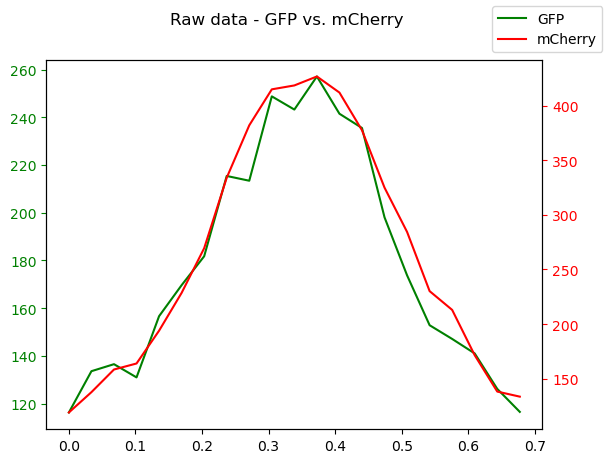

In [15]:
double_axis_plot(raw_data['X'], raw_data['GFP'], raw_data['mCherry'], title='Raw data - GFP vs. mCherry')

## Fit data to a gaussian function
using:  "curve_fit(f, xdata, ydata, p0=None, sigma=None, **kw)"  from <br>
it uses non-linear least squares fitting to fit a function f to the data <br>
### help functions:

In [16]:
# curves to fit the data to

def _polynomial(x, *p):
    poly = 0.
    for i, n in enumerate(p):
        poly += n * x ** i
    return poly

def _gauss(x, *p):
    A, mu, sigma = p
    # A - height of the curve's peak
    # mu - the position of the center of the peak
    # sigma - the standard deviation
    return A*np.exp(-( (x-mu)**2 / (2.*(sigma**2))))

# fit data to choosen curve

def fit_data_to_curve(func, x, y, p0=[1.]*3):
    coeff, _ = curve_fit(globals()[func], x, y, p0)
    yfit = [globals()[func](xx, *tuple(coeff)) for xx in x]
    return yfit, coeff


### Fit data to gauss function:
<br>
Use non-linear least squares to fit a function to data.

In [18]:
# fit gfp and mCherry data to gauss curve
yfit_gfp, coeff_gfp = fit_data_to_curve('_gauss', raw_data['X'], raw_data['GFP'])
yfit_mCherrry, coeff_mCherry = fit_data_to_curve('_gauss', raw_data['X'], raw_data['mCherry'])

# new dataframe for data after fitting
fitted_df = pd.DataFrame(np.transpose([raw_data['X'], yfit_gfp, yfit_mCherrry]), columns=['X', 'GFP', 'mCherry'])

plot fitted data:

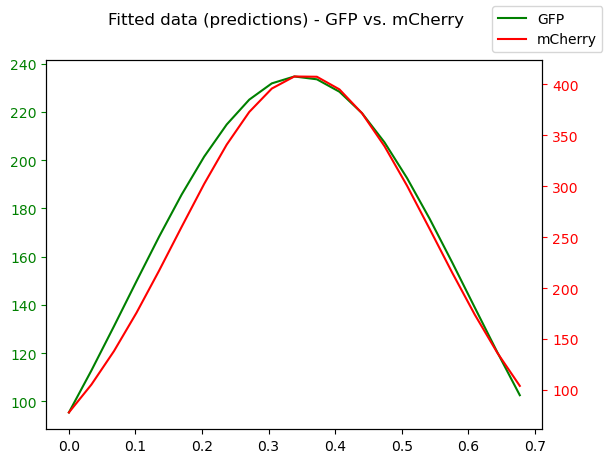

In [19]:
double_axis_plot(fitted_df['X'], fitted_df['GFP'], fitted_df['mCherry'], title='Fitted data (predictions) - GFP vs. mCherry')

plot fitted data on same y axis (same scale):

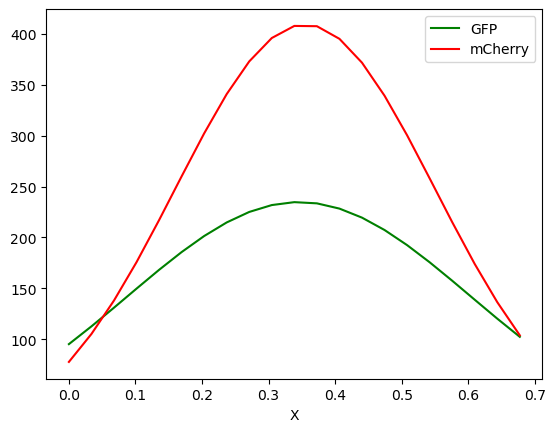

In [20]:
fitted_df.plot(x='X', y=['GFP', 'mCherry'], legend=True, color=['green', 'red']);

plot raw data and gauss fitted data

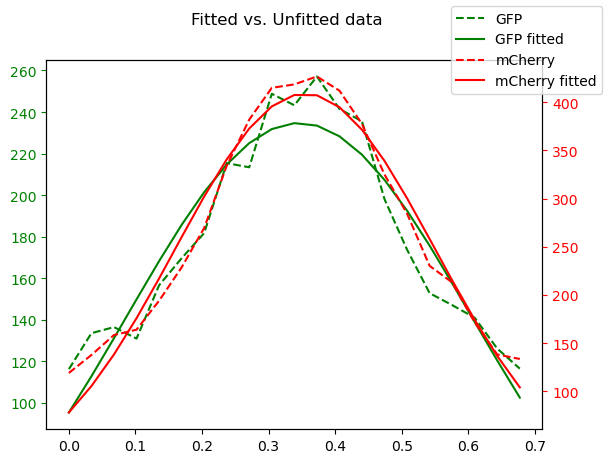

In [22]:
fig, ax1 = plt.subplots()
# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()
# plot lines on different y-axis
ax1.plot(raw_data['X'], raw_data['GFP'], color='green', linestyle='--', label='GFP')
ax1.plot(fitted_df['X'], fitted_df['GFP'], color='green', label='GFP fitted')
ax1.tick_params(axis='y', colors='green')

ax2.plot(raw_data['X'], raw_data['mCherry'], color='red', linestyle='--', label='mCherry')
ax2.plot(fitted_df['X'], fitted_df['mCherry'], color='red', label='mCherry fitted')
ax2.tick_params(axis='y', colors='red')

# add legend 
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes] 
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels)

# add title
fig.suptitle('Fitted vs. Unfitted data')

plt.show();

## Calculate std (sigma coefficient) ratios

In [23]:
GFP2mCherry = coeff_gfp[2] / coeff_mCherry[2]
GFP2mCherry

1.3219621303301774

## measure the error using Coefficient of determination (R Squared)
A data set has n values marked $y_1,...,y_n$, each associated with a fitted (or modeled, or predicted) value $\hat{y}_1,...,\hat{y}_n$. <br>
Define the residuals as $e_i = y_i−\hat{y}_i$ (forming a vector e).<br>
The mean of the observed data:<br>
$$ y_{avg} = \frac{1}{n}\sum\limits_{i=1}^{n}y_i $$<br>
The sum of squares of residuals:<br>
$$ SS_{res} = \sum\limits_{i}(y_i-\hat{y}_i)^2 = \sum\limits_{i}e_{i}^2 $$ <br>
The total sum of squares (proportional to the variance of the data): <br>
$$ SS_{total} = \sum\limits_{i}(y_i-y_{avg}) $$ <br>
The most general definition of the coefficient of determination is: <br>
$$ R^2 = 1 - \frac{SS_{res}}{SS_{total}} $$ <br>
In the best case, the modeled values exactly match the observed values, which results in: $SS_{res} = 0$ and $R^2 = 1$.<br>
A baseline model, which predicts $\hat{y}=y_{avg}$ will have $R^2 = 0$. <br>
Models that are worse than this baseline will have $R^2 < 0$


In [24]:
R_squared_gfp = r2_score(raw_data['GFP'], fitted_df['GFP'])
R_squared_mCherry = r2_score(raw_data['mCherry'], fitted_df['mCherry'])
print(f'R Squared GFP: {R_squared_gfp}')
print(f'R Squared mCherry: {R_squared_mCherry}')

R Squared GFP: 0.8943186692225669
R Squared mCherry: 0.9612526322851129


## Add smoothing step to pipline

smoot raw data using rolling average window:

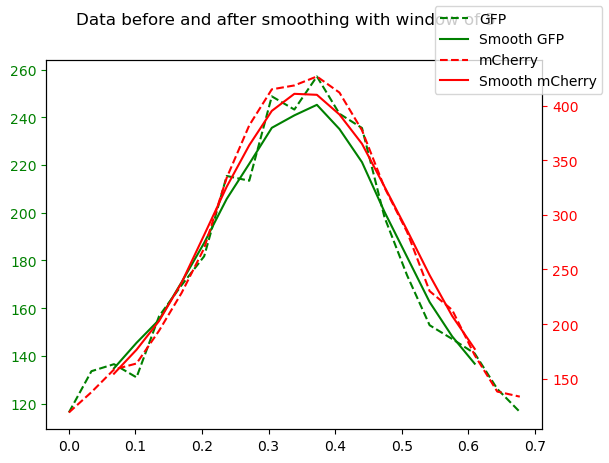

In [27]:
window_size = 5

smooth_data = raw_data.rolling(window_size).mean()[window_size-1:]

# plot smooth df
fig, ax1 = plt.subplots()
# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()
# plot lines on different y-axis
ax1.plot(raw_data['X'], raw_data['GFP'], color='green', linestyle='--', label='GFP')
ax1.plot(smooth_data['X'], smooth_data['GFP'], color='green', label='Smooth GFP')
ax1.tick_params(axis='y', colors='green')

ax2.plot(raw_data['X'], raw_data['mCherry'], color='red', linestyle='--', label='mCherry')
ax2.plot(smooth_data['X'], smooth_data['mCherry'], color='red', label='Smooth mCherry')
ax2.tick_params(axis='y', colors='red')

# add legend 
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels)

# add title
fig.suptitle(f'Data before and after smoothing with window of {window_size}')

plt.show();

Fit smooth data to gauss function:

In [28]:
# fit smooth gfp and mCherry data to gauss curve
yfit_smooth_gfp, coeff_smooth_gfp = fit_data_to_curve('_gauss', smooth_data['X'], smooth_data['GFP'], [1.] *3)
yfit_smooth_mCherrry, coeff_smooth_mCherry = fit_data_to_curve('_gauss', smooth_data['X'], smooth_data['mCherry'], [1.] *3)

# new dataframe for data after fitting
gauss_smooth_df = pd.DataFrame(np.transpose([smooth_data['X'], yfit_smooth_gfp, yfit_smooth_mCherrry]), 
                               columns=['X', 'GFP', 'mCherry'])

plot fitted smooth data:

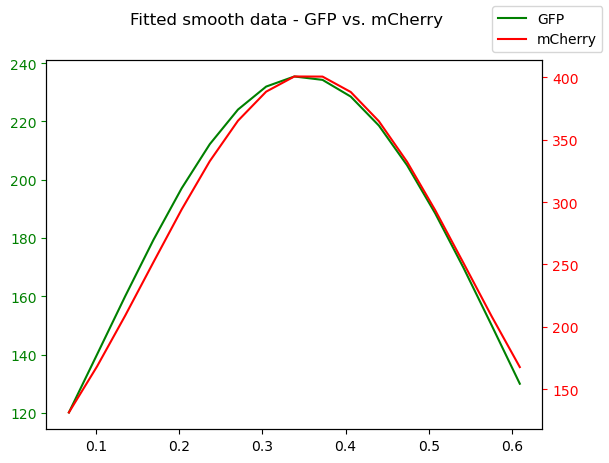

In [30]:
double_axis_plot(gauss_smooth_df['X'], gauss_smooth_df['GFP'], gauss_smooth_df['mCherry'], title='Fitted smooth data - GFP vs. mCherry')

plot fitted data on same y axis (same scale):

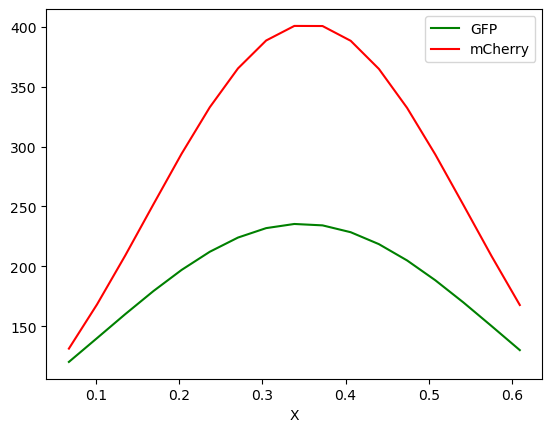

In [31]:
gauss_smooth_df.plot(x='X', y=['GFP', 'mCherry'], legend=True, color=['green', 'red']);

plot smooth data and fitted smooth data:

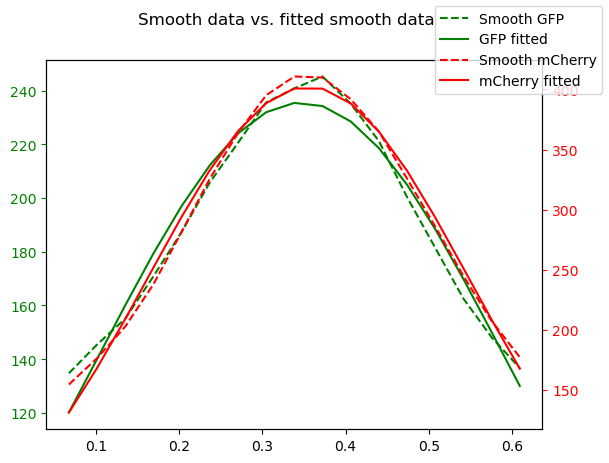

In [32]:
fig, ax1 = plt.subplots()
# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()
# plot lines on different y-axis
ax1.plot(smooth_data['X'], smooth_data['GFP'], color='green', linestyle='--', label='Smooth GFP')
ax1.plot(gauss_smooth_df['X'], gauss_smooth_df['GFP'], color='green', label='GFP fitted')
ax1.tick_params(axis='y', colors='green')

ax2.plot(smooth_data['X'], smooth_data['mCherry'], color='red', linestyle='--', label='Smooth mCherry')
ax2.plot(gauss_smooth_df['X'], gauss_smooth_df['mCherry'], color='red', label='mCherry fitted')
ax2.tick_params(axis='y', colors='red')

# add legend 
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels)

# add title
fig.suptitle(f'Smooth data vs. fitted smooth data')

plt.show();

measure the error using Coefficient of determination (R Squared):

In [33]:
R_squared_smooth_gfp = r2_score(smooth_data['GFP'], gauss_smooth_df['GFP'])
R_squared_smooth_mCherry = r2_score(smooth_data['mCherry'], gauss_smooth_df['mCherry'])
print(f'R Squared GFP: {R_squared_smooth_gfp}')
print(f'R Squared mCherry: {R_squared_smooth_mCherry}')

R Squared GFP: 0.9637626878020997
R Squared mCherry: 0.9880108315383955


In [34]:
GFP2mCherry_smooth = coeff_smooth_gfp[2] / coeff_smooth_mCherry[2]
GFP2mCherry_smooth

-1.2530397626818863